In [12]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt 
import seaborn as sns

from modelsClassifier import fit_GS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

sns.set_theme(style="whitegrid", palette=None, font_scale=1.2)

# Plot AUC-ROC curves using CV

In [13]:
datasetTimepoint = "12_uponAdmission"
target = "disease_severity"
#### Feature selection:
vars = "boruta+bestSterols"    # bestSterols
varPath = f"../../results/featureSelection/{datasetTimepoint}/{vars}.txt"

''' 
Define paths
'''
resultsPath = f"../../results/prediction/featureSelection/{datasetTimepoint}/{vars}/bestEstimator"
os.makedirs(resultsPath, exist_ok=True)
dataPath = "../../results/preprocessing/cleaned"
dataset = f"{datasetTimepoint}_{target}_cleaned.csv"

In [14]:
''' 
Read data
'''
data = pd.read_csv(f"{dataPath}/{dataset}", index_col=0)
X_orig = data.drop(target, axis=1)
y_orig = data[target]

########## Additionally split dataset to avoid overfitting ##############
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.2, stratify=y_orig)
########################

''' 
Read in variables
'''
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()


## ROC-AUC with CV

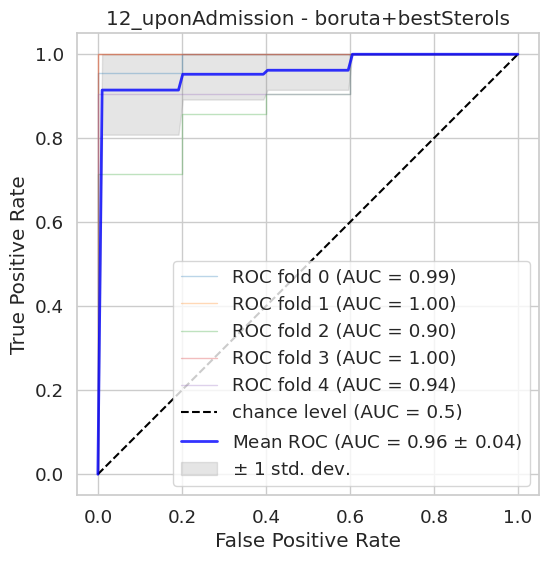

In [15]:
''' 
Run CV ROC AUC
'''
model = "RandomForest"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf = fit_GS(X_train.iloc[train,:], y_train.iloc[train], target, sel_variables, model, randomState=None)

    viz = RocCurveDisplay.from_estimator(
        clf,
        X_train.iloc[test,:],
        y_train.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"{datasetTimepoint} - {vars}",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

## Validation split confirmation

Text(0.5, 1.0, 'Validation: 12_uponAdmission - boruta+bestSterols')

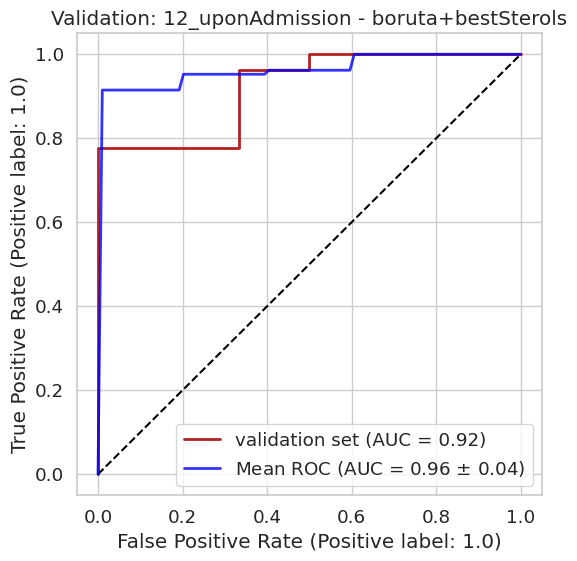

In [33]:
''' Confirm with validation split (X_test, y_test); uses a CV-fold from above '''

fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    name=f"validation set",
    lw=2,
    ax=ax,
    c="firebrick"
)
ax.plot([0, 1], [0, 1], "k--")
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8)
ax.legend()
ax.set_title(f"Validation: {datasetTimepoint} - {vars}")

# Density plots

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3, stratify=y_orig)

clf = fit_GS(X_train, y_train, target, sel_variables, model, randomState=None)
y_proba = clf.predict_proba(X_test)

proba_1 = y_proba[:,1]

<AxesSubplot: xlabel='proba_1', ylabel='Count'>

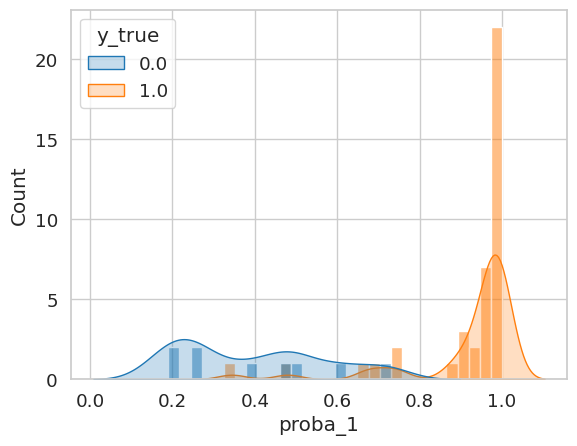

In [144]:
df = pd.concat([pd.DataFrame(y_test.tolist()), pd.Series(proba_1)], axis=1) #pd.Series(proba_0)
df.columns = ["y_true", "proba_1"] #"proba_0", 

fig, ax = plt.subplots()
sns.histplot(df,x="proba_1",hue="y_true", common_norm=False, bins=30)
sns.kdeplot(df,x="proba_1",hue="y_true", bw_adjust=.5, common_norm=False, fill=True)

#sns.displot(df,x="proba_1",hue="y_true", kind="kde", rug=True)